In [1]:
import qutip
import numpy as np
from matplotlib import pyplot as plt
import scqubits
from typing import List
import math

In [2]:
def generate_single_mapping(H_with_interaction_no_drive) -> np.ndarray:
    """
    Returns a dictionary like {(0,0,0):0,(0,0,1):1}
    """
    evals, evecs = H_with_interaction_no_drive.eigenstates()
    overlap_matrix = scqubits.utils.spectrum_utils.convert_evecs_to_ndarray(evecs)
    OVERLAP_THRESHOLD = 0.01
    product_state_names = []
    dims = H_with_interaction_no_drive.dims[0]
    system_size = len(dims)
    def generate_product_states(current_state, ele_index):
        if ele_index == system_size:
            product_state_names.append(tuple(current_state))
            return
        
        for l in range(dims[ele_index]):
            current_state[ele_index] = l
            generate_product_states(current_state.copy(), ele_index + 1)

    current_state = [0] * system_size
    generate_product_states(current_state, 0)



    total_dim = math.prod(dims)
    dressed_indices = [None] * total_dim
    for dressed_index in range(len(evals)):
        max_position = (np.abs(overlap_matrix[dressed_index, :])).argmax()
        max_overlap = np.abs(overlap_matrix[dressed_index, max_position])
        if (max_overlap**2 > OVERLAP_THRESHOLD):
            overlap_matrix[:, max_position] = 0
            dressed_indices[int(max_position)] = dressed_index
        else:
            print(f'max overlap^2 {max_overlap**2} below threshold for dressed state {dressed_index} with eval {evals[dressed_index]}')
    product_to_dressed = {}
    for product, dressed in zip(product_state_names,dressed_indices):
        product_to_dressed[product] = dressed
    return product_to_dressed

In [3]:
EJ=8
EC=2.5
EL=0.5

done:1/200
done:2/200
done:3/200
done:4/200
done:5/200
done:6/200
done:7/200
done:8/200
done:9/200
done:10/200
done:11/200
done:12/200
done:13/200
done:14/200
done:15/200
done:16/200
done:17/200
done:18/200
done:19/200
done:20/200
done:21/200
done:22/200
done:23/200
done:24/200
done:25/200
done:26/200
done:27/200
done:28/200
done:29/200
done:30/200
done:31/200
done:32/200
done:33/200
done:34/200
done:35/200
done:36/200
done:37/200
done:38/200
done:39/200
done:40/200
done:41/200
done:42/200
done:43/200
done:44/200
done:45/200
done:46/200
done:47/200
done:48/200
done:49/200
done:50/200
done:51/200
done:52/200
done:53/200
done:54/200
done:55/200
done:56/200
done:57/200
done:58/200
done:59/200
done:60/200
done:61/200
done:62/200
done:63/200
done:64/200
done:65/200
done:66/200
done:67/200
done:68/200
done:69/200
done:70/200
done:71/200
done:72/200
done:73/200
done:74/200
done:75/200
done:76/200
done:77/200
done:78/200
done:79/200
done:80/200
done:81/200
done:82/200
done:83/200
done:84/200
d

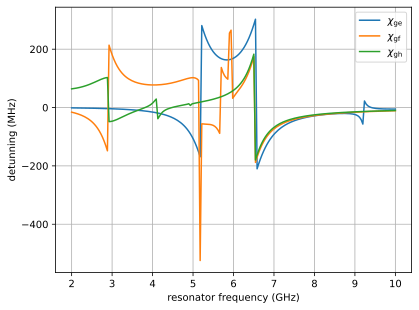

In [29]:
def dressed_transition_frequency_over_2pi(hilbertspace,s0, s1) -> float:
    return abs(hilbertspace.energy_by_dressed_index(s1) - hilbertspace.energy_by_dressed_index(s0))

def replace_non_float64_with_none(lst):
    for i in range(len(lst)):
        if type(lst[i]) is not np.float64:
            lst[i] = None
    return lst

def sweep_resonator_frequency_for_detunning(EJ=EJ,
                                        EC=EC,
                                        EL=EL,
                                        flux = 0):
    # for erasure detection, we want g0g1 detunned from e0e1 and f0f1
    # for measurement, we want one e0e1 detuned from the rest two.
    E_vals = np.linspace(2, 10, 200)
    g0g1_vals = []
    e0e1_vals = []
    f0f1_vals = []
    h0h1_vals = []

    qbt = scqubits.Fluxonium(
            EJ=EJ,
            EC=EC,
            EL=EL,
            flux=flux,
            cutoff=30,
            truncated_dim=6
        )
    num_done = 0
    num_tot = len(E_vals)
    for e in E_vals:
        osc = scqubits.Oscillator(
            E_osc=e,
            truncated_dim=10
        )
        hilbertspace = scqubits.HilbertSpace([qbt, osc])
        g_strength = 0.3
        hilbertspace.add_interaction(
            g_strength=g_strength,
            op1=qbt.n_operator,
            op2=osc.creation_operator,
            add_hc=True
        )
        hilbertspace.generate_lookup()
        product_to_dressed = generate_single_mapping(hilbertspace.hamiltonian())

        g0g1 = dressed_transition_frequency_over_2pi(hilbertspace,product_to_dressed[(0,0)],product_to_dressed[(0,1)])
        e0e1 = dressed_transition_frequency_over_2pi(hilbertspace,product_to_dressed[(1,0)],product_to_dressed[(1,1)])
        f0f1 = dressed_transition_frequency_over_2pi(hilbertspace,product_to_dressed[(2,0)],product_to_dressed[(2,1)])
        h0h1 = dressed_transition_frequency_over_2pi(hilbertspace,product_to_dressed[(3,0)],product_to_dressed[(3,1)])

        g0g1_vals.append(g0g1)
        e0e1_vals.append(e0e1)
        f0f1_vals.append(f0f1)
        h0h1_vals.append(h0h1)
        g0g1_vals = replace_non_float64_with_none(g0g1_vals)
        e0e1_vals = replace_non_float64_with_none(e0e1_vals)
        f0f1_vals = replace_non_float64_with_none(f0f1_vals)
        h0h1_vals = replace_non_float64_with_none(h0h1_vals)
        num_done+=1
        print(f"done:{num_done}/{num_tot}")
    chi_ge_MHz = []
    for a, b in zip(e0e1_vals, g0g1_vals):
        if a is None or b is None:
            chi_ge_MHz.append(None)
        else:
            chi_ge_MHz.append((a - b)*1000)
    chi_gf_MHz = []
    for a, b in zip(f0f1_vals, g0g1_vals):
        if a is None or b is None:
            chi_gf_MHz.append(None)
        else:
            chi_gf_MHz.append((a - b)*1000)
    chi_gh_MHz = []
    for a, b in zip(h0h1_vals, g0g1_vals):
        if a is None or b is None:
            chi_gh_MHz.append(None)
        else:
            chi_gh_MHz.append((a - b)*1000)
    plt.plot(E_vals, chi_ge_MHz, label=r'$\chi_{\mathrm{ge}}$')
    plt.plot(E_vals, chi_gf_MHz, label=r'$\chi_{\mathrm{gf}}$')
    plt.plot(E_vals, chi_gh_MHz, label=r'$\chi_{\mathrm{gh}}$')

    plt.legend()
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)
    plt.xlabel("resonator frequency (GHz)")
    plt.ylabel("detunning (MHz)")
    plt.show()

sweep_resonator_frequency_for_detunning(EJ=6,
                                        EC=1,
                                        EL=1,
                                        flux = 0)

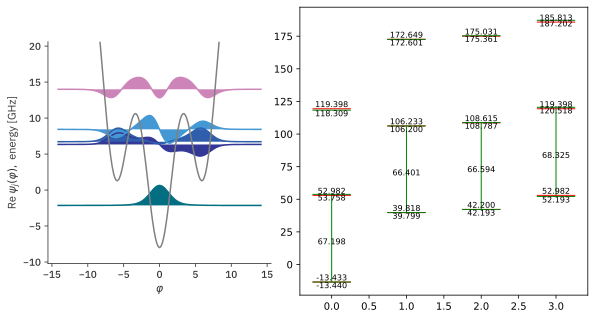

In [4]:
qbt = scqubits.Fluxonium(
        EJ=EJ,
        EC=EC,
        EL=EL,
        flux=0,
        cutoff=30,
        truncated_dim=6
    )
osc = scqubits.Oscillator(
    E_osc=qbt.eigenvals()[3]-qbt.eigenvals()[0],
    truncated_dim=50
)
hilbertspace = scqubits.HilbertSpace([qbt, osc])
g_strength = 0.3
hilbertspace.add_interaction(
    g_strength=g_strength,
    op1=qbt.n_operator,
    op2=osc.creation_operator,
    add_hc=True
)
hilbertspace.generate_lookup()
product_to_dressed = generate_single_mapping(hilbertspace.hamiltonian())

def plot_specturum(qubit, resonator, hilbertspace, max_qubit_level = 4,max_resonator_level=3,
                    flagged_transitions = [[[0,0],[0,1]],[[1,0],[1,1]],[[2,0],[2,1]],[[3,0],[3,1]]]):
    product_to_dressed = generate_single_mapping(hilbertspace.hamiltonian())
    energy_text_size = 8
    # clear_output(wait=True)
    qubit_ori_energies = qubit.eigenvals(max_qubit_level)
    resonator_ori_energies = resonator.eigenvals(max_resonator_level)
    fig, old_ax = qubit.plot_wavefunction(which = [0,1,2,3,4])
    left, bottom, width, height = 1, 0, 1, 1  
    ax = fig.add_axes([left, bottom, width, height])
    fig.set_size_inches(4, 4)
    for ql in range(0,max_qubit_level):
        for rl in range(0,max_resonator_level):
            original = (qubit_ori_energies[ql] + resonator_ori_energies[rl])* 2 * np.pi
            x1,x2 = ql-0.25,ql+0.25
            ax.plot([x1, x2], [original, original], linewidth=1, color='red')
            ax.text(ql, original, f"{original:.3f}", fontsize=energy_text_size, ha='center', va='bottom')

            dressed_state_index = product_to_dressed[(ql,rl)]
            dressed = hilbertspace.energy_by_dressed_index(dressed_state_index)* 2 * np.pi
            ax.plot([x1, x2], [dressed, dressed], linewidth=1, color='green')
            ax.text(ql, dressed, f"{dressed:.3f}", fontsize=energy_text_size, ha='center', va='top')

    for transition in flagged_transitions:
        state1, state2 = transition[0],transition[1]
        dressed_index1 = product_to_dressed[(state1[0],state1[1])]
        dressed_index2 = product_to_dressed[(state2[0],state2[1])]
        if dressed_index1!= None and dressed_index2!= None:
            energy1 = hilbertspace.energy_by_dressed_index(dressed_index1)* 2 * np.pi
            energy2 = hilbertspace.energy_by_dressed_index(dressed_index2)* 2 * np.pi
            ax.plot([state1[0], state2[0]], [energy1, energy2], linewidth=1, color='green')
            ax.text((state1[0]+ state2[0])/2, (energy1+ energy2)/2, f"{energy2-energy1:.3f}", fontsize=energy_text_size, ha='center', va='top')
        else:
            print("dressed_state_index contain None")
    plt.show()

plot_specturum(qbt, osc, hilbertspace)

In [5]:
product_to_dressed = generate_single_mapping(hilbertspace.hamiltonian())
a = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator)
a_dag = hilbertspace.op_in_dressed_eigenbasis(op=osc.creation_operator)

a = qutip.Qobj(a[:, :])# So that everything that goes into mesolve is like a product
a_dag =  qutip.Qobj(a[:, :])

(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian = (
        2 * np.pi * qutip.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)
diag_dressed_hamiltonian = qutip.Qobj(diag_dressed_hamiltonian[:, :])

def transition_frequency(hilbertspace,s0: int, s1: int) -> float:
    return ((
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        ))


w_d = transition_frequency(hilbertspace,product_to_dressed[(0,0)], product_to_dressed[(0,1)])
# w_d = transition_frequency(hilbertspace,product_to_dressed[(0,0)], product_to_dressed[(0,1)])/2+transition_frequency(product_to_dressed[(3,0)], product_to_dressed[(3,1)])/2




tot_time = 200
tlist = np.linspace(0, tot_time, tot_time*2)

matrix_element_driven = abs((a+a_dag).data.toarray()[product_to_dressed[(0,0)]][product_to_dressed[(0,1)]])


A_square = 1/tot_time
A_square = A_square/matrix_element_driven
def square_cos(t,*args):
    cos = np.cos(w_d * 2*np.pi * t)
    return  2*np.pi *A_square * cos

H_with_drive = [
    diag_dressed_hamiltonian,
    [a+a.dag(), square_cos]]



tot_time = tot_time * 2
tlist = np.linspace(0, tot_time, tot_time*2)


product_states = [(0, 0), (1, 0), (2,0), (3,0),  (0, 1), (1, 1), (2,1),(3,1)]
idxs = [product_to_dressed[(s1, s2)] for (s1, s2) in product_states]
qutip_states = [qutip.basis(hilbertspace.dimension, idx) for idx in idxs]

results = []
for i in range(4):
    temp = qutip.mesolve(
        H = H_with_drive,
        rho0 = qutip.basis(hilbertspace.dimension, product_to_dressed[(i,0)]),
        tlist = tlist,
        e_ops=[state * state.dag() for state in qutip_states]+[a,
                                                               a.dag()*a,
                                                             ],
        options=qutip.Options(store_states=True,nsteps=10000),
        progress_bar = True
    )
    results.append(temp)


10.0%. Run time:  40.51s. Est. time left: 00:00:06:04
20.0%. Run time:  81.45s. Est. time left: 00:00:05:25
30.0%. Run time: 122.29s. Est. time left: 00:00:04:45
40.0%. Run time: 163.09s. Est. time left: 00:00:04:04
50.0%. Run time: 204.13s. Est. time left: 00:00:03:24
60.0%. Run time: 244.79s. Est. time left: 00:00:02:43
70.0%. Run time: 285.09s. Est. time left: 00:00:02:02
80.0%. Run time: 325.78s. Est. time left: 00:00:01:21
90.0%. Run time: 366.17s. Est. time left: 00:00:00:40
Total run time: 406.49s


In [ ]:
plot_population_and_alpha(results,idxs,product_states,tlist,dominant_freq,nlevels = 4)